# 0.0 IMPORTS

In [1]:
import warnings 
import pickle

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

import xgboost as xgb
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn.ensemble import ExtraTreesClassifier

import scikitplot as skplt

from IPython.display         import Image
from IPython.display         import HTML

## 0.1 Helper Functions

In [2]:
def metrics_score(model_name, model, X, y):
    
    scoring = ['precision', 'recall']
    
    scores = cross_validate(model, X, y, cv=5, scoring=scoring)
        
    return pd.DataFrame({'Modelo': model_name,
                         'Precisão': scores['test_precision'].mean(),
                         'Recall': scores['test_recall'].mean()}, index=[0])

def precision_at_k(df, k=2000):
    
    df = df.sort_values('score', ascending=False)

    df = df.reset_index(drop=True)

    df['ranking'] = df.index + 1
    df['precision_at_k'] = df['response'].cumsum() /df['ranking']
    
    return df.loc[k, 'precision_at_k']

def recall_at_k(df, k=2000):
    
    df = df.sort_values('score', ascending=False)

    df = df.reset_index(drop=True)

    df['ranking'] = df.index + 1
    df['recall_at_k'] = df['response'].cumsum() / df['response'].sum()
    
    return df.loc[k, 'recall_at_k']

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [22, 11]
    plt.rcParams['font.size'] = 23
    
    display( HTML( '<style>.container { width: 90% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    

    warnings.filterwarnings("ignore")

In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [4]:
df_raw = pd.read_csv('../data/raw/train.csv', low_memory=False)

In [5]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

In [7]:
new_columns = ['id',
            'gender',
            'age',
            'driving_license',
            'region_code',
            'previously_insured',
            'vehicle_age',
            'vehicle_damage',
            'annual_premium',
            'policy_sales_channel',
            'vintage',
            'response']
    
df1.columns = new_columns

## 1.1 Dimensão dos Dados

In [111]:
print(f'Número de linhas: {df1.shape[0]}')
print(f'Número de colunas: {df1.shape[1]}')

Número de linhas: 381109
Número de colunas: 12


## 1.2 Data Types


In [45]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Check NA

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Estatistica Descritiva

In [11]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.4.1 Atributos Numéricos

In [12]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


### 1.4.2 Atributos Categóricos

In [13]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

# 2.0 FEATURE ENGINEERING

In [8]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

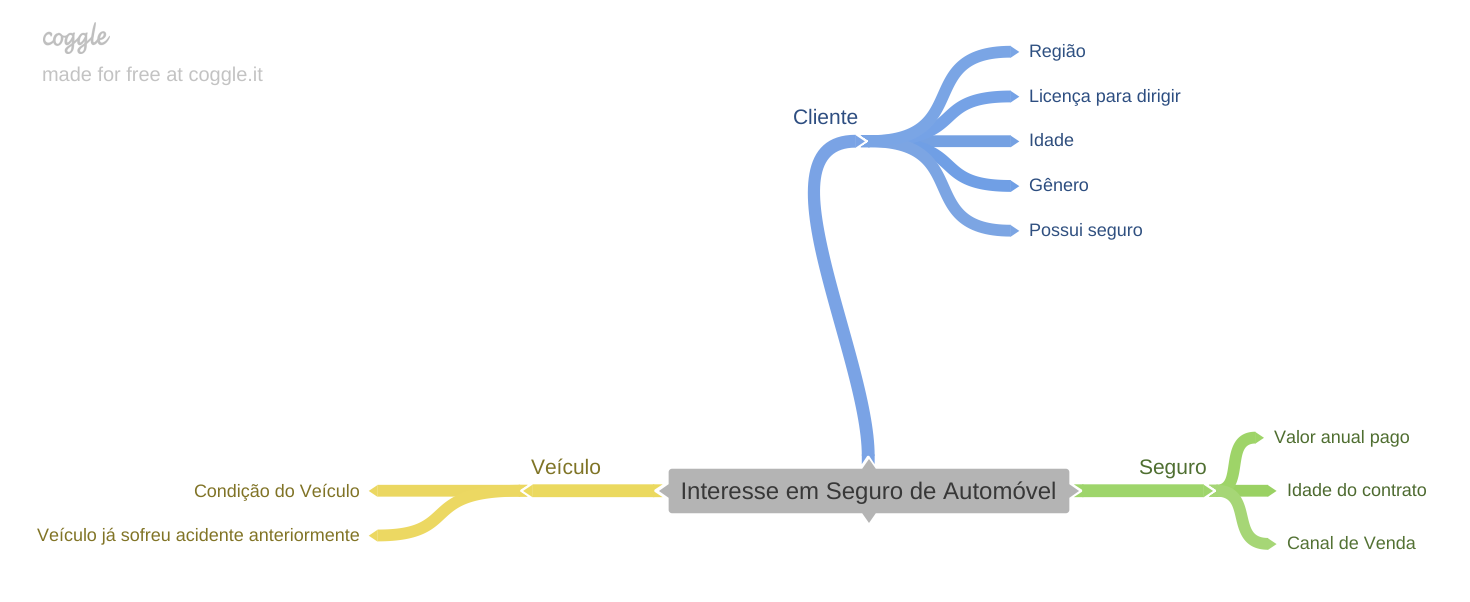

In [24]:
Image('../images/Interesse_em_Seguro_de_Automvel.png')

## 2.2 Lista de Hipoteses

**H1.** Interesse em contratar seguro aumenta quando a pessoa possui veiculo que já sofreu damage anteriormente.

**H2.** Interesse em contratar seguro aumenta em regiões quando o carro está em condição nova.

**H3.** Interesse em contratar seguro aumenta em regiões com mais acidentes registrados.  

**H4.** Interesse em contratar seguro aumenta em pessoas com idade maior a 40 anos.

**H5.** Acidentes acontecem com pessoas que não possuem liçenca para dirigir. 

**H6.** Acidentes acontecem mais com pessoas que possuem seguro.

**H7.** O pagamento anual aumenta quando os veículos já sofreram acidente anteriormente.


## 2.3 Feature Engineering

In [9]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)

# 3.0 FILTRAGEM DOS DADOS

In [10]:
df3 = df2.copy()

# 4.0 ANALISE EXPLORATÓRIA DOS DADOS

In [11]:
df4 = df3.copy()

## 4.1 Analise Univariada

In [12]:
# gender
sns.boxplot(x='response', y='age', data=df4)

NameError: name 'df4' is not defined

<AxesSubplot:xlabel='age', ylabel='Count'>

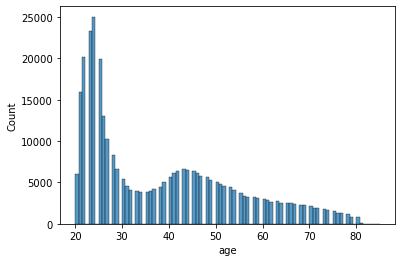

In [19]:
# age
aux001 = df4[df4['response'] == 0]
aux000 = df4[df4['response'] == 1]
sns.histplot(aux001['age'])

<AxesSubplot:xlabel='age', ylabel='Count'>

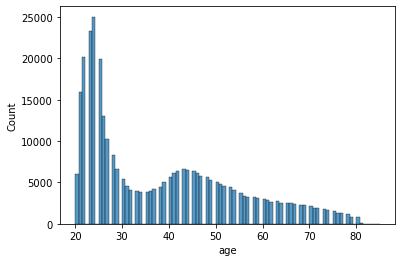

In [20]:
sns.histplot(aux001['age'])

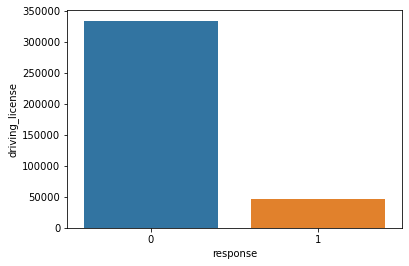

In [21]:
# driving_license
aux000 = df4[['response', 'driving_license']].groupby('response').sum().reset_index()
sns.barplot(y='driving_license', x='response', data=aux000);

In [22]:
aux000 = df4[['response', 'driving_license']].groupby('response').sum().reset_index()
aux000['driving_license_percentage'] = aux000['driving_license'] / aux000['driving_license'].sum()
aux000

,response,driving_license,driving_license_percentage
0,0,333628,0.877283
1,1,46669,0.122717


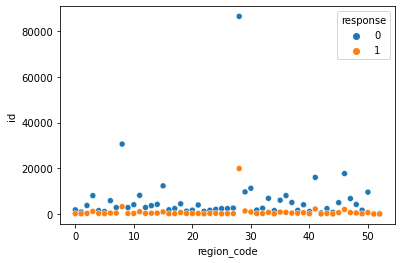

In [23]:
# region_code
aux0 = df4[['id', 'region_code', 'response']].groupby(['response', 'region_code']).count().reset_index()
sns.scatterplot(hue='response', y='id', x='region_code', data=aux0);

In [24]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x / x.sum(), axis=1 )

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [25]:
# vehicle_age
df4[['response', 'vehicle_age']].value_counts(normalize=True).reset_index()

,response,vehicle_age,0
0,0,between_1_2_year,0.434285
1,0,below_1_year,0.413488
2,1,between_1_2_year,0.091328
3,0,over_2_years,0.029663
4,1,below_1_year,0.018897
5,1,over_2_years,0.012338


In [26]:
# vehicle_damage
df4['vehicle_damage'].value_counts()

1    192413
0    188696
Name: vehicle_damage, dtype: int64

C:\Users\vinic\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


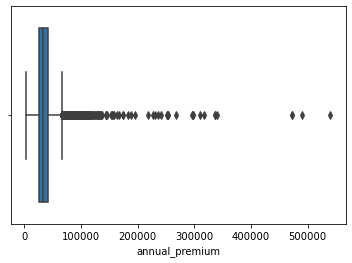

In [27]:
# annual_premium
aux001 = df4[df4['response'] == 0]
aux000 = df4[df4['response'] == 1]

sns.boxplot(aux000['annual_premium']);

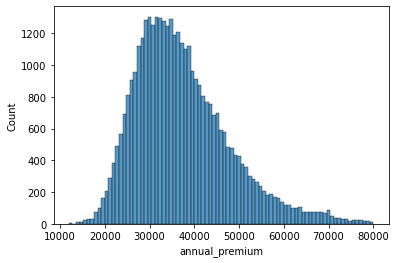

In [28]:
aux001 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000) & (df4['response'] == 1)]
sns.histplot(aux001['annual_premium']);

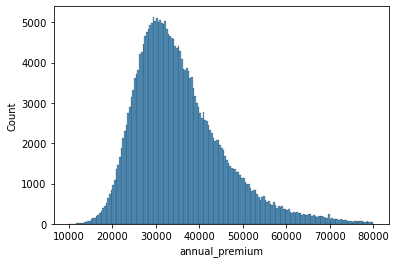

In [29]:
aux000 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000) & (df4['response'] == 0)]
sns.histplot(aux000['annual_premium']);

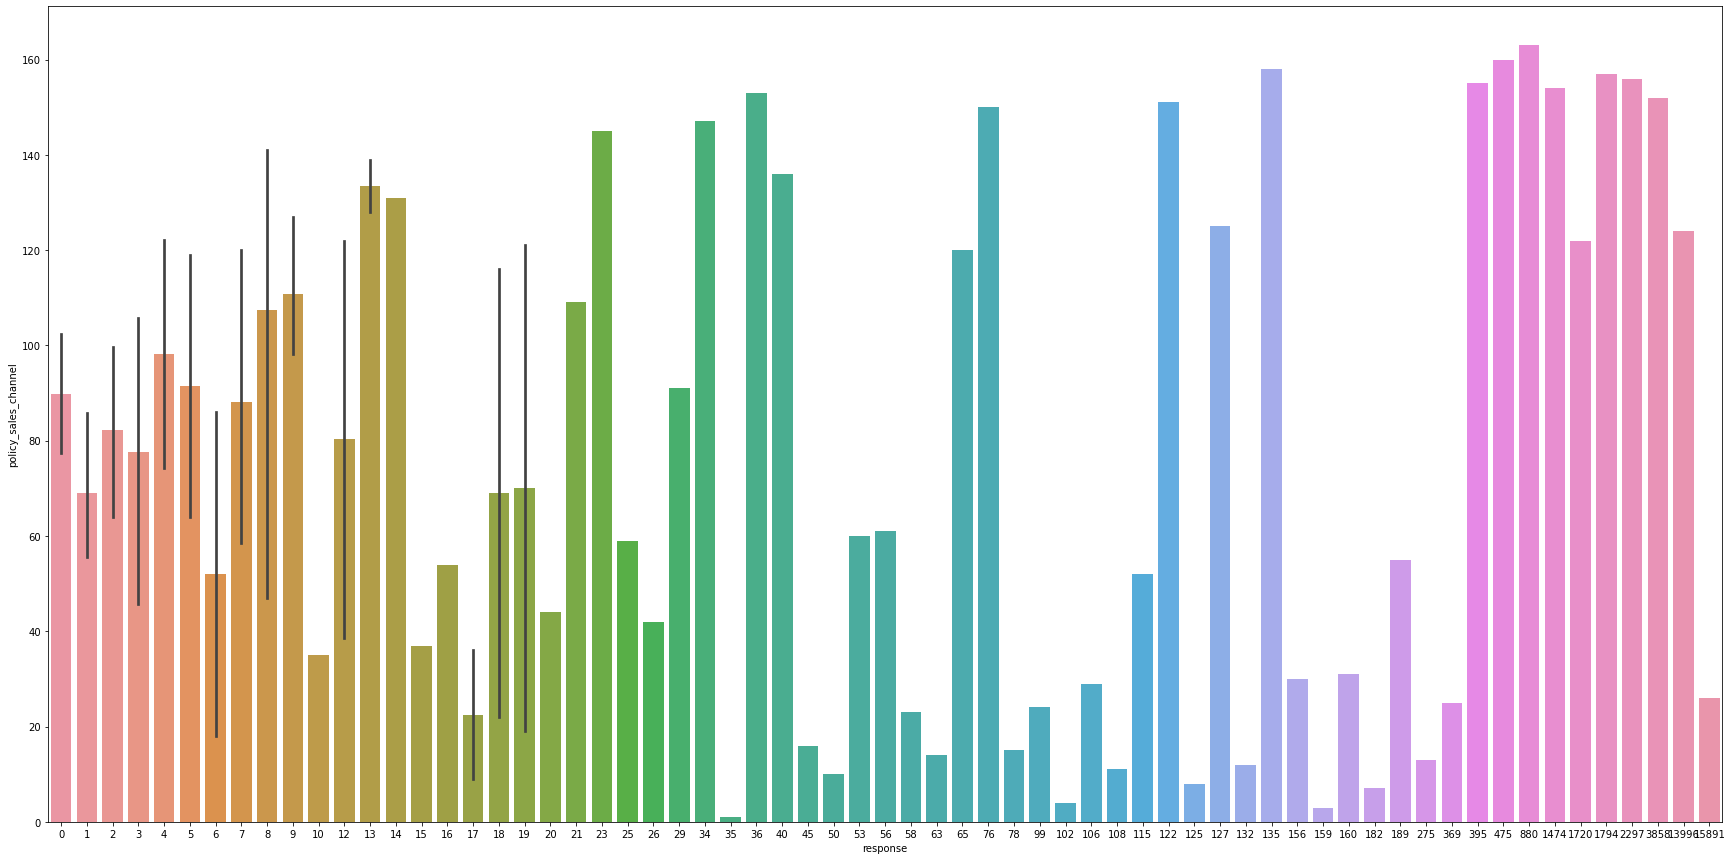

In [30]:
# policy_sales_channel
import matplotlib.pyplot as plt

plt.subplots(figsize=(30,15))
aux0 =df4[['response', 'policy_sales_channel']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(y='policy_sales_channel', x='response', data=aux0);

<AxesSubplot:xlabel='vintage', ylabel='Count'>

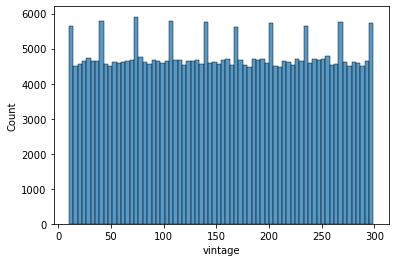

In [31]:
# vintage
aux0 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux0)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

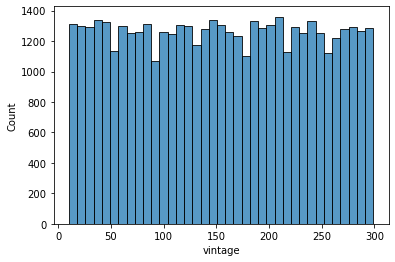

In [32]:
# vintage
aux0 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux0)

<AxesSubplot:xlabel='response', ylabel='id'>

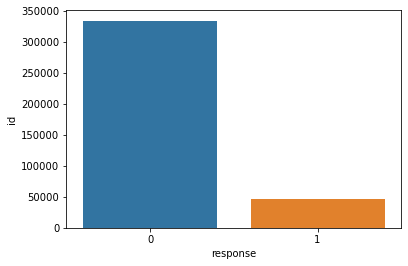

In [33]:
# response
aux0 = df4[['response', 'id']].groupby('response').count().reset_index()
sns.barplot(x='response', y='id', data=aux0)

## 4.2 Analise Bivariada

**H1.** Interesse em contratar seguro aumenta em regiões com mais acidentes registrados.

**H2.** Interesse em contratar seguro aumenta em regiões quando o carro está em condição nova.

**H3.** Interesse em contratar seguro aumenta em regiões com mais acidentes registrados.  

**H4.** Interesse em contratar seguro aumenta em pessoas com idade maior a 40 anos.

**H5.** Acidentes acontecem com pessoas que não possuem liçenca para dirigir. 

**H6.** Acidentes acontecem mais com pessoas que possuem seguro.

**H7.** O pagamento anual aumenta quando os veículos já sofreram acidente anteriormente.

## **H1.** Interesse em contratar seguro aumenta quando a pessoa possui veiculo que já sofreu dano anteriormente.
**VERDADEIRA** Interesse em contratar seguro aumenta quando a pessoa que possui carro sofreu dano anteriormente.

<AxesSubplot:xlabel='vehicle_damage', ylabel='id'>

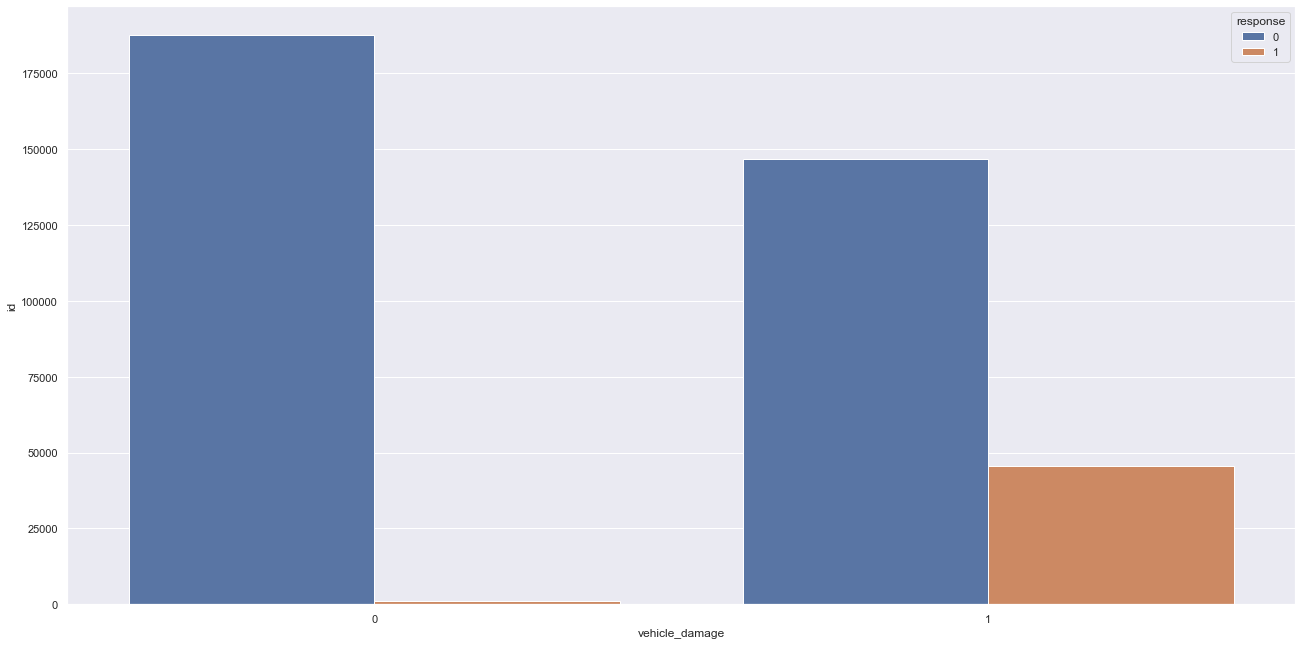

In [44]:
aux = df4[['response', 'vehicle_damage', 'id']].groupby(['response', 'vehicle_damage']).count().reset_index()
sns.barplot(hue='response', y='id', x='vehicle_damage', data=aux)

## H2. Interesse em contratar seguro aumenta enquanto a idade de uso do veículo aumenta.
**VERDADEIRA** Interesse em contratar seguro aumenta enquanto a idade de uso do veículo está entre 1 e 2 anos de uso.

<AxesSubplot:xlabel='vehicle_age', ylabel='id'>

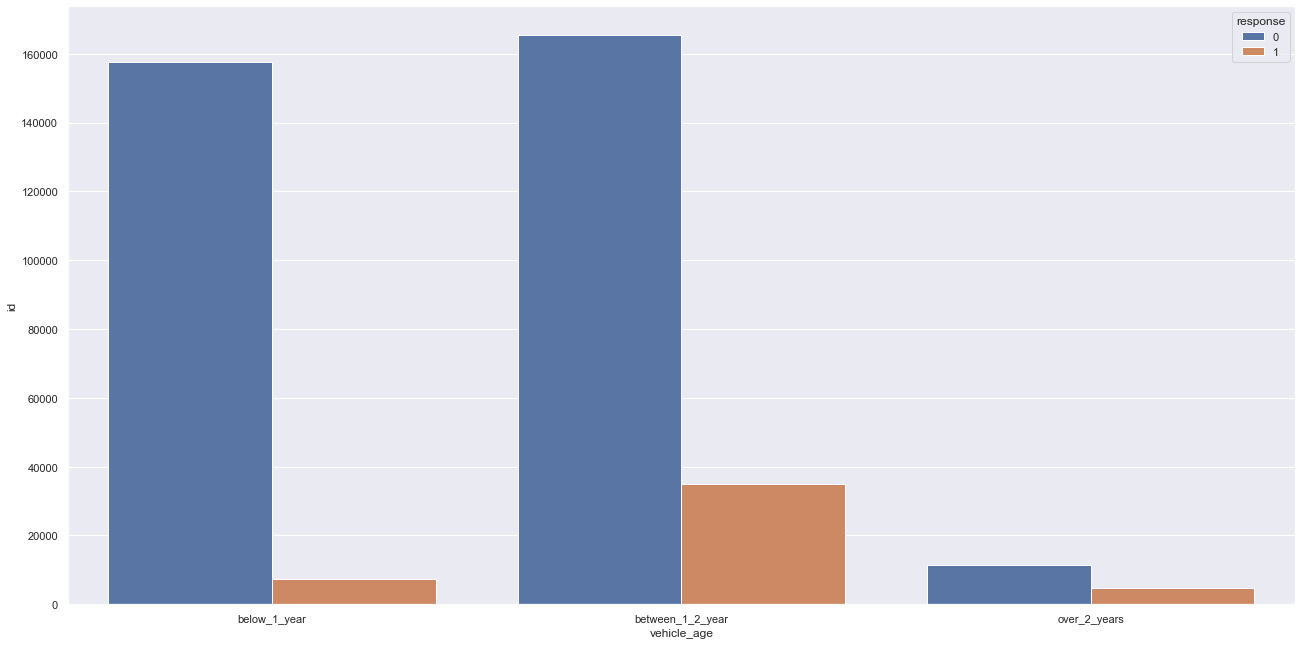

In [12]:
aux = df4[['response', 'id', 'vehicle_age']].groupby(['response', 'vehicle_age']).count().reset_index()

sns.barplot(x='vehicle_age', y='id', hue='response', data=aux)

## **H4.** Interesse em contratar seguro aumenta quando a idade aumenta.
**VERDADEIRA** Interesse em contratar seguro aumenta conforme a idade da pessoa aumenta. PLUS => O interesse diminui depois que as pessoas atingem a casa dos 45 anos.

<AxesSubplot:xlabel='age', ylabel='response'>

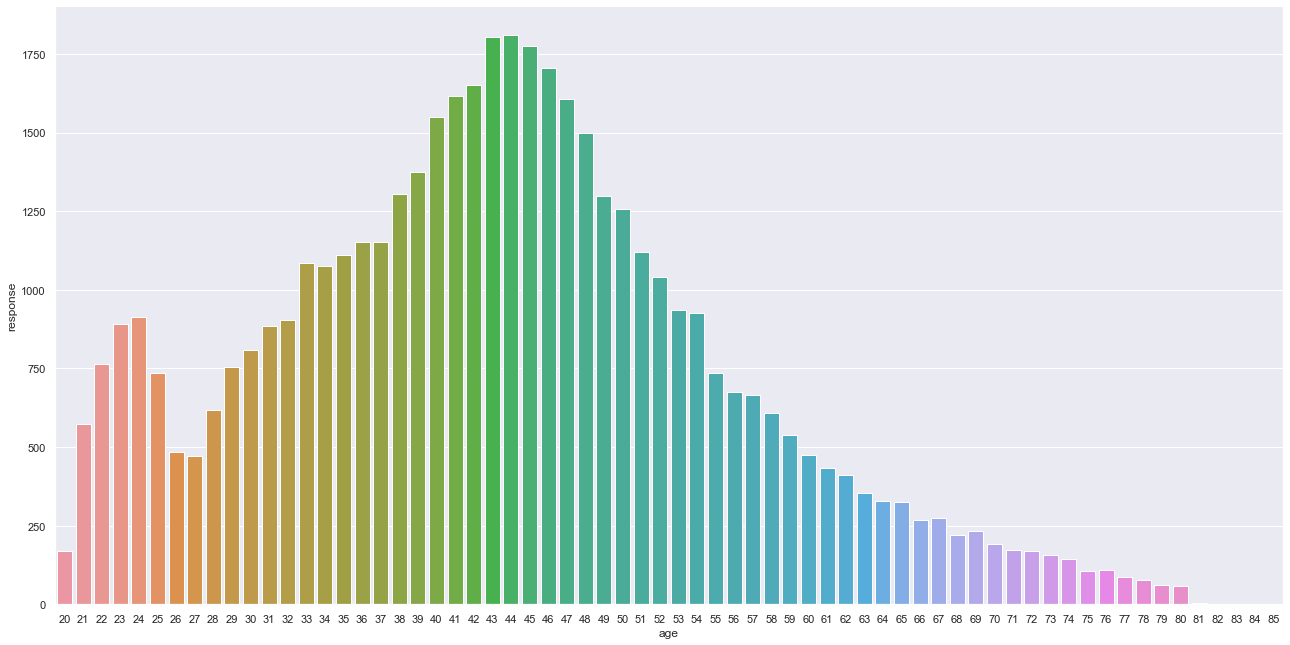

In [41]:
aux = df4[['age', 'response']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux)

## **H5.** Danos em veiculos acontecem mais quando pessoas que não possuem liçenca para dirigir.
**VERDADEIRA** Danos acontecem mais quando pessoas pssuem licença para dirigir.

<AxesSubplot:xlabel='driving_license', ylabel='id'>

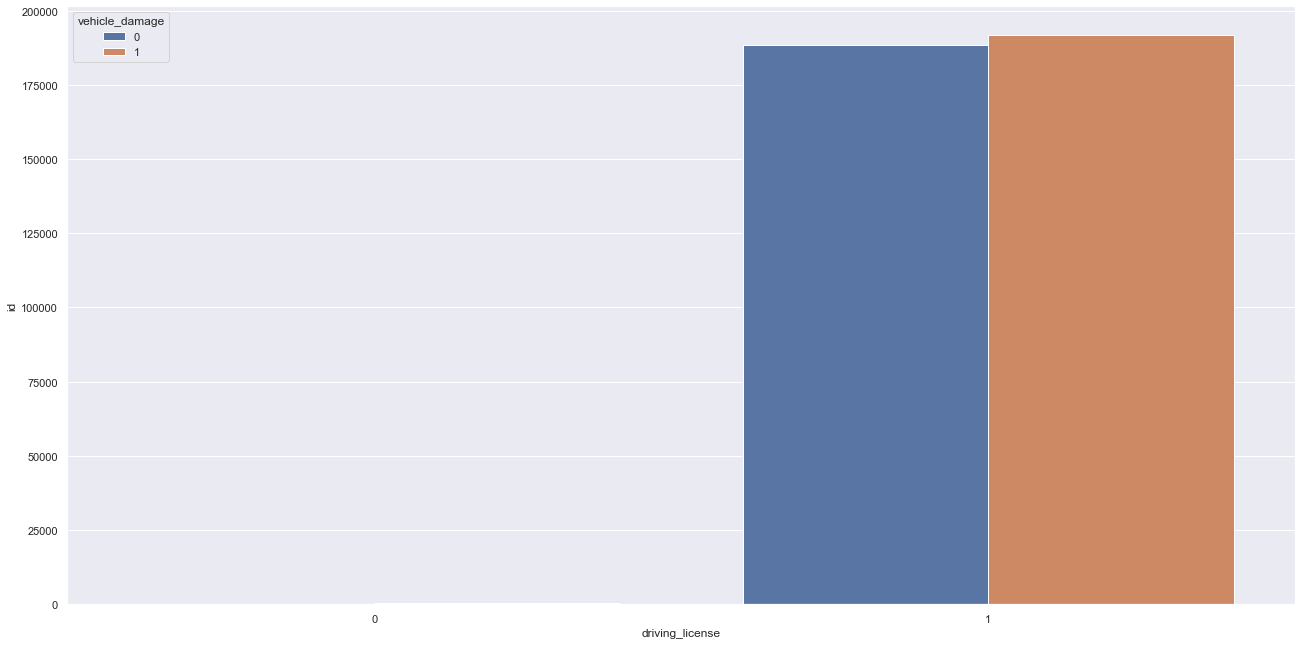

In [45]:
aux = df4[['vehicle_damage', 'id', 'driving_license']].groupby(['vehicle_damage', 'driving_license']).count().reset_index()
sns.barplot(x='driving_license', hue='vehicle_damage', y='id', data=aux)

## **H6.** Acidentes acontecem mais com pessoas que possuem seguro.
**FALSA** Danos acontecem mais quando a pessoa não possui seguro.

In [62]:
aux

,vehicle_damage,previously_insured,id
0,0,0,4562382043
1,0,1,31426185864
2,1,0,34732274094
3,1,1,1901383494


## **H7.** O pagamento anual aumenta quando os veículos já sofreram acidente anteriormente.
**VERDADEIRA** A receita por cliente aumenta quando veículo já sofreu dano anteriormente.

<AxesSubplot:xlabel='vehicle_damage', ylabel='annual_premium'>

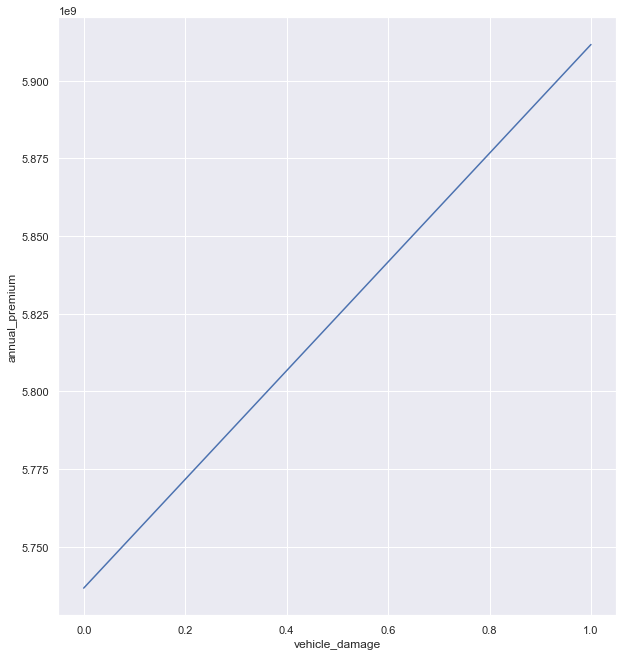

In [72]:
aux = df4[['annual_premium', 'vehicle_damage']].groupby('vehicle_damage').sum().reset_index()

plt.subplot(1, 2, 1)
sns.lineplot(x='vehicle_damage', y='annual_premium', data=aux)

## 4.3 Analise Multivariada

# 5.0 PREPARAÇÃO DOS DADOS

In [19]:
df5 = df4.copy()

In [20]:
X = df4.drop('response', axis=1)
y = df4['response']

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1 Padronização

In [17]:
ss = pp.StandardScaler()

df5['annual_premium'] =  ss.fit_transform( df5[['annual_premium']].values )

with open("C:/Users/vinic/Desktop/Pessoal/repos/ranking-potenciais-clientes/src/features/annual_premium.pkl", 'wb') as f:
    pickle.dump(ss, f)

## 5.2 Rescala 

In [18]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# age
df5[['age']] = mms_age.fit_transform ( df5[['age']].values )
with open("C:/Users/vinic/Desktop/Pessoal/repos/ranking-potenciais-clientes/src/features/mms_age.pkl", 'wb') as f:
    pickle.dump(mms_age, f)

# vintage
df5[['vintage']] = mms_vintage.fit_transform ( df5[['vintage']].values )
with open("C:/Users/vinic/Desktop/Pessoal/repos/ranking-potenciais-clientes/src/features/mss_vintage.pkl", 'wb') as f:
    pickle.dump(mms_vintage, f)

## 5.3 Encodificação 

In [19]:
# gender
target_encoding_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encoding_gender)
with open("C:/Users/vinic/Desktop/Pessoal/repos/ranking-potenciais-clientes/src/features/target_encoding_gender.pkl", 'wb') as f:
    pickle.dump(target_encoding_gender, f)

# region_code
target_encoding_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encoding_region_code)
with open("C:/Users/vinic/Desktop/Pessoal/repos/ranking-potenciais-clientes/src/features/target_encoding_region_code.pkl", 'wb') as f:
    pickle.dump(target_encoding_region_code, f)

# vehicle_age
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
with open("C:/Users/vinic/Desktop/Pessoal/repos/ranking-potenciais-clientes/src/features/fe_policy_sales_channel.pkl", 'wb') as f:
    pickle.dump(fe_policy_sales_channel, f)

## 5.4 Validação da Preparação

In [42]:
#x_validation['annual_premium'] =  ss.fit_transform( x_validation[['annual_premium']].values )
#
#x_validation[['age']] = mms_age.fit_transform (x_validation[['age']].values )
#
#x_validation[['vintage']] = mms_vintage.fit_transform ( x_validation[['vintage']].values )
#
#x_validation.loc[:, 'gender'] = x_validation['gender'].map(target_encoding_gender)
#
#x_validation.loc[:, 'region_code'] = x_validation['region_code'].map(target_encoding_region_code)
#
#x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'])
#
#x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(fe_policy_sales_channel)
#
## fill na
#x_validation.fillna(0, inplace=True)

# 6.0 SELEÇÃO DAS FEATURES

## 6.1 Importância das Features

In [40]:
# definindo modelo
#forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)
#
## preparação dos dados
#x_train_n = df5.drop(['id', 'response'], axis=1)
#y_train_n = y_train.values
#forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage    0.271480
0                annual_premium    0.244448
0                           age    0.165426
0                   region_code    0.105023
0                vehicle_damage    0.069581
0          policy_sales_channel    0.060956
0            previously_insured    0.055036
0      vehicle_age_below_1_year    0.013788
0  vehicle_age_between_1_2_year    0.006523
0                        gender    0.004837
0      vehicle_age_over_2_years    0.002374
0               driving_license    0.000528


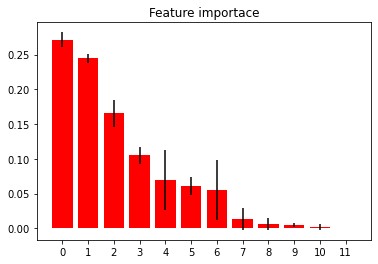

In [41]:
#importances = forest.feature_importances_
#std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
#indices = np.argsort(importances)[::-1]
#
## printa o ranking das features
#print("Feature ranking:")
#df = pd.DataFrame()
#for i, j in zip(x_train_n, forest.feature_importances_):
#    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
#    df = pd.concat([df, aux], axis=0)
#print(df.sort_values('importance', ascending=False))
#
## Plot das importâncias em destaque da floresta com base em impureza
#
#plt.figure()
#plt.title('Feature importace')
#plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align="center")
#plt.xticks(range(x_train_n.shape[1]))
#plt.xlim([-1, x_train_n.shape[1]])
#plt.show()


# 7.0 MACHINE LEARNING MODELLING

In [21]:
cols_select = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_train = df5[cols_select]

x_val = x_validation[cols_select]
y_val = y_validation

## 7.1 KNN 

In [43]:
# model
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# treino do modelo
knn_model.fit(x_train, y_train)

# predição - Poder de Generalização do Modelo
yhat_knn = knn_model.predict_proba(x_val)

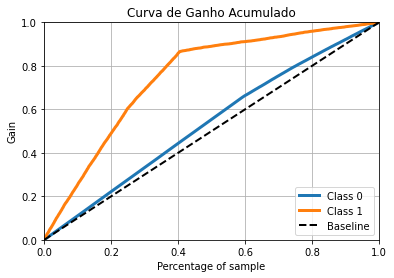

In [44]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, title = 'Curva de Ganho Acumulado');

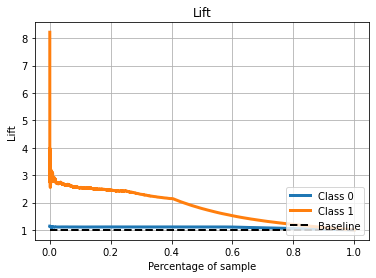

In [45]:
# curva lift
skplt.metrics.plot_lift_curve( y_val, yhat_knn,title = 'Lift');

In [46]:
from sklearn.model_selection import cross_validate

knn_results_cv = metrics_score('KNN', knn_model, x_val, y_val)
knn_results_cv

,Modelo,Precisão,Recall
0,KNN,0.341145,0.133571


## 7.2 Regressão Logistica

In [47]:
# definindo modelo
lr = lm.LogisticRegression(n_jobs=-1, random_state=42)

# treino do modelo
lr.fit(x_train, y_train)

# predição do modelo
yhat_lr = lr.predict_proba(x_val)

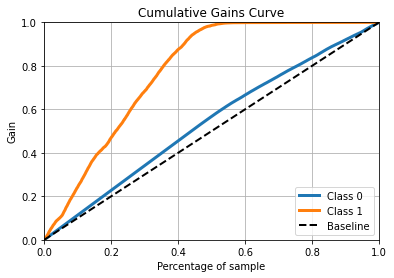

In [48]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr);

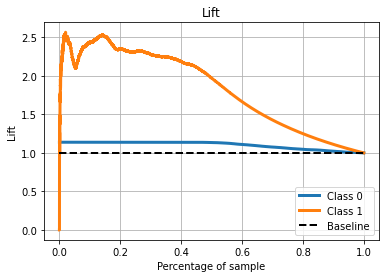

In [49]:
# curva lift
skplt.metrics.plot_lift_curve( y_val, yhat_lr,title = 'Lift');

## 7.3 XGBoost

In [50]:
# definindo modelo
bst = xgb.XGBClassifier(n_jobs=-1, random_state=42)

# treino do modeloimport xgboost as xgb
bst.fit(x_train, y_train)

# predição
yhat_xgb = bst.predict_proba(x_val)

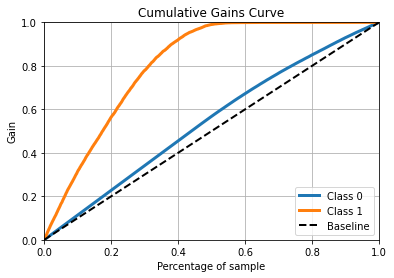

In [51]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb);

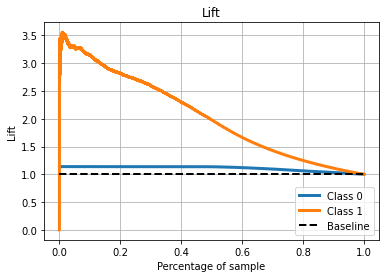

In [52]:
# curva lift
skplt.metrics.plot_lift_curve( y_val, yhat_xgb, title = 'Lift');

## XGBoost - Cross Validation

In [53]:
xgb_cv_results = metrics_score('XGBoost', bst, x_val, y_val)
xgb_cv_results

,Modelo,Precisão,Recall
0,XGBoost,0.38988,0.043877


## 7.4 Random Forest

In [54]:
# definindo modelo
clf = en.RandomForestClassifier(n_jobs=-1, random_state=42)

# treinamento do modelo
clf.fit(x_train, y_train)

# predição do modelo
yhat_rf = clf.predict_proba(x_val)

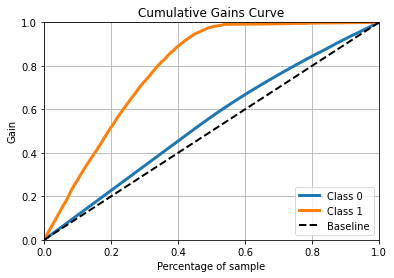

In [55]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf);

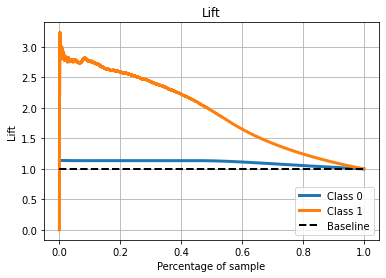

In [56]:
# curva lift
skplt.metrics.plot_lift_curve( y_val, yhat_rf, title = 'Lift');

## Random Forest - Cross Validation

In [57]:
rf_cv_results = metrics_score('Random Forest', clf, x_val, y_val)
rf_cv_results

,Modelo,Precisão,Recall
0,Random Forest,0.356468,0.105218


## 7.6 Comparação dos Modelos

In [58]:
modelling_result = pd.concat( [knn_results_cv, xgb_cv_results, rf_cv_results] )
modelling_result.sort_values( 'Recall', ascending=False )

,Modelo,Precisão,Recall
0,KNN,0.341145,0.133571
0,Random Forest,0.356468,0.105218
0,XGBoost,0.389880,0.043877


# 8.0 HYPERPARAMETERS FINE TUNING

## 8.1 Random Search CV

In [59]:
from sklearn.model_selection import RandomizedSearchCV

In [60]:
#n_estimators = [100, 200, 300, 500]
#
#max_depth = [3, 5, 10, None]
#
#min_samples_leaf = [1, 2, 4]
#
#min_samples_split = [1, 2, 4]
#
#max_features = ['auto', 'sqrt']
#
#
## creating random grid
#
#params = {
#    'n_estimators': n_estimators,
#    'max_depth': max_depth,
#    'min_samples_leaf': min_samples_leaf,
#    'min_samples_split': min_samples_split,
#    'max_features': max_features,
#         }

In [61]:
#random_search = RandomizedSearchCV(estimator=bst,
#                                  param_distributions=params, 
#                                  n_iter=2,
#                                  n_jobs=-1, 
#                                  cv=5, 
#                                  verbose=2,
#                                  random_state=42)
#
#random_search.fit( x_train, y_train)
#random_search.best_params_

In [62]:
params_tuned = {'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 5}

## 8.2 Modelo Final

In [25]:
## model
#xgboost_tuned = xgb.XGBClassifier(n_estimators=300,
#                                min_samples_split=2,
#                                min_samples_leaf=4,
#                                max_features='auto',
#                                max_depth=5)
#
#xgboost_tuned.fit( x_train, y_train)
#
## predict
#yhat_xgb_tuned = xgboost_tuned.predict_proba( x_val )
#
## result
#xgb_tuned_result = metrics_score('XGB', xgboost_tuned, x_val, y_val)
#xgb_tuned_result

[15:36:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:37:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_leaf", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:37:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1

,Modelo,Precisão,Recall
0,XGB,0.358586,0.075381


# 9.0 METRICAS DE PERFOMANCE DO MODELO PARA O NEGÓCIO

<AxesSubplot:xlabel='base_cum_perc', ylabel='lift'>

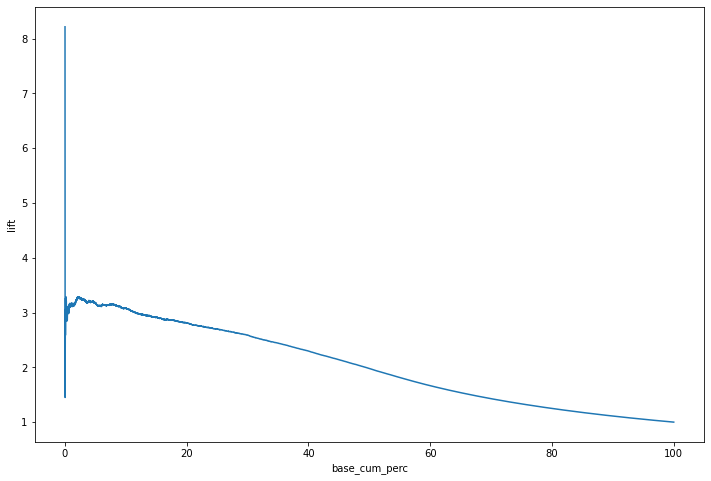

In [64]:
results = pd.DataFrame()
results['prediction'] = yhat_xgb_tuned[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results ) 

In [65]:
# Compute bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 )

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
8,0.80,0.803407,3,96.408863,3.213629,1.000000,93.195234
7,0.70,0.700994,20,560.795355,2.803977,0.777153,557.991378
6,0.60,0.600742,71,1706.107230,2.402968,0.582713,1703.704262
5,0.50,0.500015,504,10080.296803,2.000059,0.416081,10078.296744
4,0.40,0.400008,3138,50208.999538,1.600032,0.277388,50207.399507
3,0.30,0.300008,9355,112262.915140,1.200031,0.166435,112261.715109
2,0.20,0.200018,10509,84079.423918,0.800071,0.083220,84078.623847
1,0.10,0.100002,8075,32300.510667,0.400006,0.027739,32300.110661
0,0.01,0.000004,44547,7.689334,0.000017,0.000001,7.689316


<AxesSubplot:xlabel='base', ylabel='revenue'>

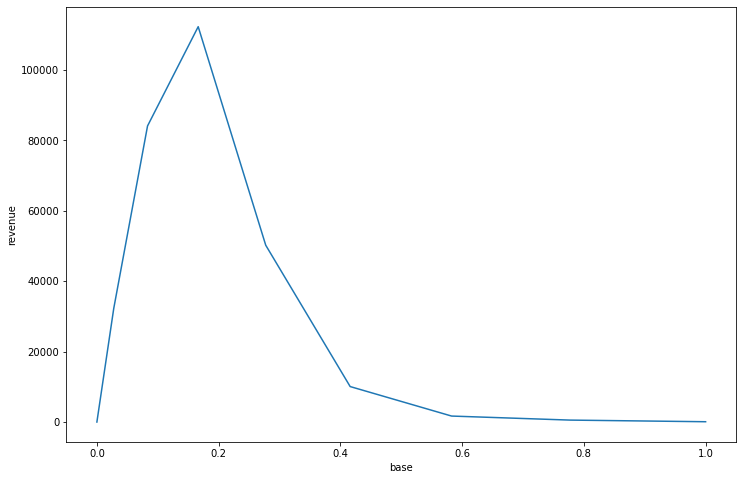

In [66]:
plt.figure( figsize=(12,8))
aux = df[df['propensity_score'] >= 0.1]
sns.lineplot( x='base', y='revenue', data=aux )

Próximos Passos:
- Criar APP no Heroku 

# 10.0 DEPLOY DO MODELO PARA PRODUÇÃO

In [26]:
#with open("C:/Users/vinic/Desktop/Pessoal/repos/ranking-potenciais-clientes/src/models/xgb_tuned.pkl", 'wb') as f:
#    pickle.dump(xgboost_tuned, f)

## 10.1 Criação da Classe Health Insurance Cross Selling

In [20]:
import pickle
import numpy as np
import pandas as pd

class HealthInsurance(object):

    def __init__(self):

        self.home_path = 'C:/Users/vinic/Desktop/Pessoal/repos/ranking-potenciais-clientes/'
        self.annual_premium = pickle.load( open( self.home_path + "src/features/annual_premium.pkl", 'rb'))
        self.fe_policy_sales_channel = pickle.load( open( self.home_path + 'src/features/fe_policy_sales_channel.pkl', 'rb'))
        self.mms_age = pickle.load( open( self.home_path + 'src/features/mms_age.pkl', 'rb'))
        self.mss_vintage = pickle.load( open( self.home_path + 'src/features/mss_vintage.pkl', 'rb'))
        self.target_encoding_gender = pickle.load( open( self.home_path + 'src/features/target_encoding_gender.pkl', 'rb'))
        self.target_encoding_region_code = pickle.load( open( self.home_path + 'src/features/target_encoding_region_code.pkl', 'rb'))

    def data_cleaning (self, data):

        new_columns = ['id',
                        'gender',
                        'age',
                        'driving_license',
                        'region_code',
                        'previously_insured',
                        'vehicle_age',
                        'vehicle_damage',
                        'annual_premium',
                        'policy_sales_channel',
                        'vintage',
                        'response']

        data.columns = new_columns

        return data

    def feature_engineering(self, data):

        data['vehicle_age'] = data['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_2_year' if x == '1-2 Year' else 'below_1_year')

        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)

        return data

    def data_preparation( self, data ):
        # anual premium - StandarScaler
        data['annual_premium'] = self.annual_premium.transform( data[['annual_premium']].values )

        # Age - MinMaxScaler
        data['age'] = self.mms_age.transform( data[['age']].values )

        # Vintage - MinMaxScaler
        data['vintage'] = self.mss_vintage.transform( data[['vintage']].values )

        #gender - One Hot Encoding / Target Encoding
        data.loc[:, 'gender'] = data['gender'].map( self.target_encoding_gender )

        #region_code - Target Encoding / Frequency Encoding
        data.loc[:, 'region_code'] = data['region_code'].map( self.target_encoding_region_code )

        #vehicle_age - One Hot Encoding / Frequency Encoding
        data = pd.get_dummies( data, prefix='vehicle_age', columns=['vehicle_age'] )

        # policy_sales_channel - Target Encoding / Frequency Encoding
        data.loc[:, 'policy_sales_channel'] = data['policy_sales_channel'].map( self.fe_policy_sales_channel )

        # Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                         'policy_sales_channel']

        return data[ cols_selected ]

    def get_prediction(self, model, original_data, test_data):

        #model prediction
        pred = model.predict_proba(test_data)

        #join predict into original data
        original_data['score'] = pred[:, 1].tolist()

        return original_data.to_json( orient='records', date_format='iso')

## 10.2 API Handler

In [19]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance import HealthInsurance

path = 'C:/Users/vinic/Desktop/Pessoal/repos/ranking-potenciais-clientes/'
model = pickle.load(open(path + 'src/models/xgb_tuned.pkl', 'rb'))

ModuleNotFoundError: No module named 'healthinsurance'

In [ ]:
#inicializa API
app = Flask(__name__)


@app.route("/healthinsurance/predict", methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # existe dados
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else:
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
        
        # instanciando a Classe HealthInsurance
        pipeline = HealthInsurace()
        
        # data_cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # get_prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    else:
        return Response('{}', status=200, mimetype='application/json')
            
if __name__ == '__main__':
    app.run( '0.0.0.0')

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://192.168.9.171:5000/ (Press CTRL+C to quit)
192.168.9.171 - - [20/Jul/2022 13:46:29] "GET / HTTP/1.1" 404 -
192.168.9.171 - - [20/Jul/2022 13:46:29] "GET /favicon.ico HTTP/1.1" 404 -


## 10.3 API Tester

In [23]:
import requests

In [24]:
df_test = x_validation
df_test['response'] = y_validation

In [25]:
df_test = df_test.sample(10)

In [26]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [27]:
data

'[{"id": 225393, "gender": "Male", "age": 26, "driving_license": 1, "region_code": 31.0, "previously_insured": 0, "vehicle_age": "below_1_year", "vehicle_damage": 0, "annual_premium": 2630.0, "policy_sales_channel": 152.0, "vintage": 104, "response": 0}, {"id": 263885, "gender": "Female", "age": 27, "driving_license": 1, "region_code": 50.0, "previously_insured": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "annual_premium": 32689.0, "policy_sales_channel": 152.0, "vintage": 242, "response": 0}, {"id": 177045, "gender": "Female", "age": 22, "driving_license": 1, "region_code": 49.0, "previously_insured": 0, "vehicle_age": "below_1_year", "vehicle_damage": 1, "annual_premium": 19038.0, "policy_sales_channel": 152.0, "vintage": 46, "response": 0}, {"id": 301388, "gender": "Male", "age": 26, "driving_license": 1, "region_code": 8.0, "previously_insured": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "annual_premium": 28407.0, "policy_sales_channel": 152.0, "vintage": 71

In [32]:
# API Call
#url = 'http://127.0.0.1:5000/predict'
url = 'https://model001-marcus.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 500


In [51]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
9,137167,0.103502,0.153846,1,0.186877,1,below_1_year,1,2.813720,152.0,0.882353,0,0.471052
7,274687,0.103502,0.138462,1,0.127003,1,below_1_year,1,0.269840,124.0,0.155709,0,0.314358
2,307039,0.103502,0.046154,1,0.150223,1,below_1_year,1,-0.071892,152.0,0.044983,0,0.259114
4,178926,0.137779,0.338462,1,0.186877,0,below_1_year,1,0.516351,26.0,0.851211,0,0.242116
3,37705,0.103502,0.292308,1,0.186877,1,below_1_year,1,0.903204,24.0,0.487889,0,0.229212
